# IMPORT STATEMENT

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 7.2 MB/s 
     |████████████████████████████████| 596 kB 74.0 MB/s 
     |████████████████████████████████| 895 kB 64.9 MB/s 
     |████████████████████████████████| 77 kB 9.1 MB/s 
     |████████████████████████████████| 6.6 MB 55.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import collections
import numpy as np
from nltk.corpus import stopwords
import copy
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch

from torch.utils.data import TensorDataset,random_split
from torch.nn import CrossEntropyLoss
from transformers import BertTokenizer
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import numpy as np
import random
import time
from sklearn.metrics import classification_report,accuracy_score,f1_score

import gc
import glob
import re
from sklearn.utils import shuffle

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# DATA IMPORT

In [ ]:
# data = pd.read_csv('/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/implicit_explicit_nothate_classification.csv')
# print(data.shape)
# data['class'] = data['class'].replace(['implicit_hate','not_hate','explicit_hate'],[2,0,1])
# size = 1000
# nothate_data = data[data['class']==0]
# ehate_data = data[data['class']==1]
# ihate_data = data[data['class']==2]
# df = nothate_data.copy(deep=True)
# # df = df.append(ehate_data.sample(n=size, random_state=1))
# df = df.append(ihate_data.copy(deep=True))

# df = shuffle(df).reset_index()
# df.to_csv('/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/implicit_nothate_binary_full.csv')

In [ ]:
# df = pd.read_csv('/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/implicit_nothate_binary_full.csv')
df = pd.read_csv('/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/implicit_explicit_nothate_balanced.csv')
# df = df[df['class']!=1].reset_index()
# df = df.drop(labels=['index'], axis=1)
# df['class'] = df['class'].replace([2],[1])
print(df.columns)
print(df.shape)

labels0 = collections.Counter(df['class'])
print(labels0)
# labels1 = collections.Counter(data['class'])
print(df.columns)
df.head()

Index(['post', 'class'], dtype='object')
(5000, 2)
Counter({0: 2000, 2: 2000, 1: 1000})
Index(['post', 'class'], dtype='object')


,post,class
0,"< < we love dead "" brown-skinned "" "" people ...",1
1,more black on black murders in chicago this we...,0
2,pl . review the #security of sh ji and close d...,0
3,rt : . stupid screed . jihad terror isn't a r...,2
4,filthy jews like always pretend to be white wh...,1


In [ ]:
def modify_tweets(data):
  # print(data.columns)
  modified_tweets = []
  for text in data:

      #To remove @AnyName from the tweets
      text=re.sub(r"@[a-zA-z0-9]*\s+","",text) 
      text=re.sub(r"@[a-zA-z0-9]*:","",text)
      text=re.sub(r"@[a-zA-z0-9]*","",text)  
      text=re.sub(r"@[a-zA-z0-9]*$","",text)
      
      #To remove links
      text=re.sub(r"^https://t.co/[a-zA-Z0-9]*\s+"," ",text)    
      text=re.sub(r"\s+https://t.co/[a-zA-Z0-9]*\s+"," ",text)  
      text=re.sub(r"\s+https://t.co/[a-zA-Z0-9]*$"," ",text)    
      
      #To Convert all the tweets to low.
      # text=text.lower() 
      
      #To remove the shorthands
      text=re.sub(r"that's","that is ",text)
      text=re.sub(r"there's","there is ",text)
      text=re.sub(r"what's","what is ",text)
      text=re.sub(r"where's","where is ",text)
      text=re.sub(r"it's","it is ",text)
      text=re.sub(r"who's","who is ",text)
      text=re.sub(r"i'm","i am ",text)
      text=re.sub(r"she's","she is ",text)
      text=re.sub(r"he's","he is ",text)
      text=re.sub(r"they're","they are ",text)
      text=re.sub(r"who're","who are ",text)
      text=re.sub(r"ain't","am not ",text)
      text=re.sub(r"wouldn't","would not ",text)
      text=re.sub(r"shouldn't","should not ",text)
      text=re.sub(r"can't","cannot ",text)
      text=re.sub(r"couldn't","could not ",text)
      text=re.sub(r"won't","will not ",text)
      
      #To remove the single character
      text=re.sub(r"\s+[a-z]\s+"," ",text)
      text=re.sub(r"\s+[a-z]$"," ",text)
      text=re.sub(r"^[a-z]\s+"," ",text)
      
      #To remove non-word character
      text=re.sub(r"^[「人間はいわば感情に左右される生き物である」]*\s+"," ",text)
      text=re.sub(r"\s+[「人間はいわば感情に左右される生き物である」]*\s+"," ",text)
      text=re.sub(r"\s+[「人間はいわば感情に左右される生き物である」]*$"," ",text)
      text=re.sub(r"[!@$,%^&*\"><]*","",text)
      text=re.sub(r"\."," ",text)
      
      #To remove duplicate spaces
      text=re.sub(r"\s+"," ",text)
      
      #To remove digits 
      text=re.sub(r"\d"," ",text)
      
      #To remove non-word characters
      text=re.sub(r"\W"," ",text)
      
      modified_tweets.append(text)
  return modified_tweets

In [ ]:
print(df.head(5)['post'])
df['post'] = modify_tweets(df['post'])
print(df.head(5)['post'])

0     < < we love dead  " brown-skinned " " people ...
1    more black on black murders in chicago this we...
2    pl . review the #security of sh ji and close d...
3     rt : . stupid screed . jihad terror isn't a r...
4    filthy jews like always pretend to be white wh...
Name: post, dtype: object
0     we love dead brown skinned people and we fund...
1    more black on black murders in chicago this we...
2    pl review the  security of sh ji and close dow...
3     rt   stupid screed jihad terror isn t race wh...
4    filthy jews like always pretend to be white wh...
Name: post, dtype: object


In [ ]:
distr = torch.tensor(list(labels0.values())).to(device)
distr

tensor([1000, 2000, 2000], device='cuda:0')

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/implicit_explicit_nothate_classification.csv')
print(df.shape)
df['class'] = df['class'].replace(['implicit_hate','not_hate','explicit_hate'],[2,0,1])

print(collections.Counter(df['class']))

implicit_df = df[df['class']==2]
explicit_df = df[df['class']==1]
nothate_df = df[df['class']==0]
print("Implicit Posts")
imp_len = list(map(len,implicit_df['post']))
print("avg: ", np.mean(imp_len), "max :", np.max(imp_len), "min :", np.min(imp_len), "count: ", len(imp_len))

print("Explicit Posts")
exp_len = list(map(len,explicit_df['post']))
print("avg: ", np.mean(exp_len), "max :", np.max(exp_len), "min :", np.min(exp_len), "count: ", len(exp_len))

print("Not Hate Posts")
nh_len = list(map(len,nothate_df['post']))
print("avg: ", np.mean(nh_len), "max :", np.max(nh_len), "min :", np.min(nh_len), "count: ", len(nh_len))

(21480, 2)
Counter({0: 13291, 2: 7100, 1: 1089})
Implicit Posts
avg:  95.30183098591549 max : 801 min : 7 count:  7100
Explicit Posts
avg:  88.08264462809917 max : 363 min : 7 count:  1089
Not Hate Posts
avg:  86.41057858701377 max : 322 min : 4 count:  13291


Text(0.5, 1.0, 'Class Distribution')

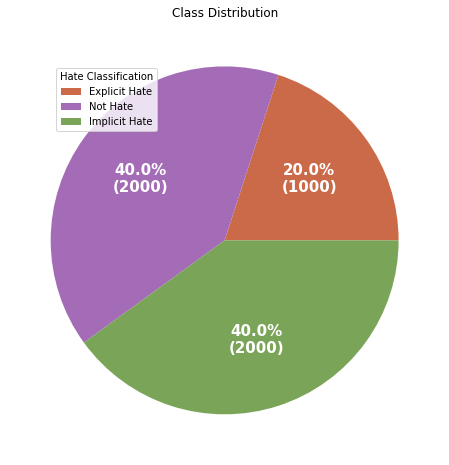

In [ ]:
names = ['Explicit Hate','Not Hate','Implicit Hate']
count = list(labels0.values())
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(count, autopct=lambda pct: func(pct, count),textprops=dict(color="w"), labels=names, colors=['#cb6a49','#a46cb7','#7aa457'])
ax.legend(wedges, names,
          title="Hate Classification",
          loc="center left",
          bbox_to_anchor=(0.1, 0.45, 0.2, 0.75))
plt.setp(autotexts, size=15, weight="bold")
ax.set_title("Class Distribution")

# FUNCTIONS

In [ ]:
def encoder_generator(documents):
    
    doc_index = []
    input_ids = []
    attention_masks =[]

    for index,doc in enumerate(documents):
        
        doc_index.append(index)
        
        encoded_dict = tokenizer.encode_plus(doc,
                                             add_special_tokens=True,
                                             max_length=128,
                                             pad_to_max_length=True,
                                             truncation = True,
                                             return_attention_mask=True,
                                             return_tensors='pt')
        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids,dim=0)
    attention_masks = torch.cat(attention_masks,dim=0)
    sent_index = torch.tensor(doc_index)

    return sent_index,input_ids,attention_masks


In [ ]:
def predictions_labels(preds,labels):
    pred = np.argmax(preds,axis=1).flatten()
    label = labels.flatten()
    return pred,label

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]]).cuda()

In [ ]:
def train(model, optimizer, train_data_loader):
    total_train_loss = 0
    total_train_acc = 0
    total_logits = []
    
    model.train() # set model in train mode for batchnorm and dropout layers in bert model
    
    for step,batch in enumerate(train_data_loader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
            
        output = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels.long())
        loss = output.loss
        logits = output.logits
        total_logits.extend(logits)
        # active_logits = logits.view(-1, 3)
        # loss_fct = CrossEntropyLoss(weight= distr)
        # loss = loss_fct(active_logits.astype(dtype=torch.float64), b_labels.astype(dtype=torch.float64))

        total_train_loss+=loss.item()

        total_train_acc+=categorical_accuracy(logits, b_labels).item()
        loss.backward()
            
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            
        optimizer.step()
            
        scheduler.step() #go ahead and update the learning rate
            
    avg_train_loss = total_train_loss/len(train_data_loader)
    avg_train_acc = total_train_acc/len(train_data_loader)
    
    return avg_train_loss,avg_train_acc, total_logits

In [ ]:
def evaluate(model, valid_data_loader):
    model.eval()
        
    total_eval_accuracy = 0
    total_eval_loss = 0
    number_of_eval_steps= 0
    
    all_true_labels = []
    all_pred_labels = []

    for batch in valid_data_loader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            output = model(b_input_ids,
                                attention_mask= b_input_mask,
                                labels = b_labels.long())
        loss = output.loss
        logits = output.logits

        total_eval_loss+=loss.item()

        logits = logits.detach().cpu().numpy()

        label_ids = b_labels.to('cpu').numpy()

        pred,true = predictions_labels(logits,label_ids)
        
        all_pred_labels.extend(pred)
        all_true_labels.extend(true)

    print(classification_report(all_pred_labels,all_true_labels))
    avg_val_accuracy = accuracy_score(all_pred_labels,all_true_labels)
    macro_f1_score = f1_score(all_pred_labels,all_true_labels,average='macro')
    
    avg_val_loss = total_eval_loss/len(valid_data_loader)

    print("accuracy = {0:.2f}".format(avg_val_accuracy))
    
    return avg_val_loss,avg_val_accuracy,macro_f1_score

In [ ]:
def evaluate_test(model, test_data_loader):
    model.eval()
        
    total_eval_accuracy = 0
    total_eval_loss = 0
    number_of_eval_steps= 0
    
    all_true_labels = []
    all_pred_labels = []
    
    all_sentence_id=[]

    for batch in test_data_loader:
        b_sentence_id = batch[0].to(device)
        b_input_ids = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_labels = batch[3].to(device)

        sent_ids = b_sentence_id.to('cpu').numpy()
        all_sentence_id.extend(sent_ids)
        
        with torch.no_grad():

            output = model(b_input_ids,
                                attention_mask= b_input_mask,
                                labels = b_labels.long())
            
        loss = output.loss
        logits = output.logits
        
        total_eval_loss+=loss.item()

        logits = logits.detach().cpu().numpy()

        label_ids = b_labels.to('cpu').numpy()
        

        pred,true = predictions_labels(logits,label_ids)
        
        all_pred_labels.extend(pred)
        
        all_true_labels.extend(true)

    print(classification_report(all_pred_labels,all_true_labels))
    avg_val_accuracy = accuracy_score(all_pred_labels,all_true_labels)
    
    avg_val_loss = total_eval_loss/len(test_data_loader)

    print("accuracy = {0:.2f}".format(avg_val_accuracy))
    
    return avg_val_loss,avg_val_accuracy,all_sentence_id,all_pred_labels


In [ ]:
def predict_logits(model, data_loader):
    model.eval()
        
    # total_eval_accuracy = 0
    # total_eval_loss = 0
    # number_of_eval_steps= 0
    
    # all_true_labels = []
    all_pred_labels = []
    
    all_sentence_id=[]

    for batch in data_loader:
        b_sentence_id = batch[0].to(device)
        b_input_ids = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        # b_labels = batch[3].to(device)

        sent_ids = b_sentence_id.to('cpu').numpy()
        all_sentence_id.extend(sent_ids)
        
        with torch.no_grad():

            output = model(b_input_ids,
                                attention_mask= b_input_mask)
                                # labels = b_labels.long())
            
        # loss = output.loss
        logits = output.logits
        
        # total_eval_loss+=loss.item()

        logits = logits.detach().cpu().numpy()

        # label_ids = b_labels.to('cpu').numpy()
        

        # pred,true = predictions_labels(logits,label_ids)
        pred = np.argmax(logits,axis=1).flatten()
        all_pred_labels.extend(pred)
        
        # all_true_labels.extend(true)

    # print(classification_report(all_pred_labels,all_true_labels))
    # avg_val_accuracy = accuracy_score(all_pred_labels,all_true_labels)
    
    # avg_val_loss = total_eval_loss/len(test_data_loader)

    # print("accuracy = {0:.2f}".format(avg_val_accuracy))
    
    return all_sentence_id,all_pred_labels


In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [ ]:
def plot_vc(acc_train, acc_val):
  e = range(epochs)
  plt.plot(e, acc_train, 'g', label='Training Accuracy')
  plt.plot(e, acc_val, 'b', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
def plot_lc(loss_train, loss_val):
  e = range(epochs)
  plt.plot(e, loss_train, 'g', label='Training Loss')
  plt.plot(e, loss_val, 'b', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# Load Dataset

In [ ]:
size = int(len(df)*0.8)
train_data = df[:size]
test_data = df[size:]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

max_length = 0
for sentence in train_data['post']:
    length = len(tokenizer.tokenize(sentence))
    if length > max_length:
        max_length  = length
print("max token length in train_data is: ",max_length)

sent_index,input_ids,attention_masks = encoder_generator(list(train_data['post']))
print(type(sent_index), type(input_ids), type(attention_masks))
print("sent_index.shape, input_ids.shape, attention_masks.shape ", sent_index.shape,input_ids.shape,attention_masks.shape)
test_sent_index,test_input_ids,test_attention_masks = encoder_generator(list(test_data['post']))
print("test_sent_index.shape, test_input_ids.shape, test_attention_masks.shape ", test_sent_index.shape,test_input_ids.shape,test_attention_masks)
print('Original: ', train_data['post'][0])
print('Token IDs:', input_ids[0])

dataset = TensorDataset(input_ids,attention_masks,torch.tensor(train_data['class']))
test_dataset = TensorDataset(test_sent_index,test_input_ids,test_attention_masks,torch.tensor(test_data['class'].values))
train_size = int(0.8*len(dataset))
val_size = len(dataset)-train_size
train_dataset,val_dataset = random_split(dataset,[train_size,val_size])
print('train data samples is {}'.format(len(train_dataset)))
print("valid data samples is {}".format(len(val_dataset)))
print("test data samples is {}".format(len(test_dataset)))

bs=64

train_data_loader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=bs)
valid_data_loader = DataLoader(val_dataset,
                              sampler=SequentialSampler(val_dataset),
                              batch_size=bs)
test_data_loader = DataLoader(test_dataset,
                            sampler=SequentialSampler(test_dataset),
                            batch_size=bs)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

max token length in train_data is:  86


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
sent_index.shape, input_ids.shape, attention_masks.shape  torch.Size([4000]) torch.Size([4000, 128]) torch.Size([4000, 128])
test_sent_index.shape, test_input_ids.shape, test_attention_masks.shape  torch.Size([1000]) torch.Size([1000, 128]) tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Original:   we love dead brown skinned people and we fund white supremacist racist killers with our bffs  alec luv bffs 
Token IDs: tensor([  101,  2057,  2293,  2757,  2829, 19937,  2111,  1998,  2057,  4636,
         2317, 10514, 28139, 22911,  2923, 16939, 15978,  2007,  2256, 28939,
        10343,  9752, 11320,  2615, 28939, 10343,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,

# Model Train and Test and Tune - 2 labels

This cell is to be run only when dataset contains 2 labels - Implicit and Not Hateful posts. 
Intent is to compare the accuracy and tune the model to the benchmark paper.

In [ ]:
# del model
# gc.collect()
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
#                                                      num_labels=2,
#                                                      output_attentions=False,
#                                                      output_hidden_states=False,
#                                                      )
# model.to(device)

# optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)

# epochs=10
# total_steps = len(train_data_loader) * epochs

# scheduler = get_linear_schedule_with_warmup(optimizer,
#                                            num_warmup_steps=0,
#                                            num_training_steps=total_steps)

# total_t0 = time.time()

# seed_val = 42

# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)

# best_macro_f1 = float('0')

# train_acc_hs = []
# val_acc_hs = []
# train_loss_hs = []
# val_loss_hs = []
# best_logits = []

# for epoch in range(epochs):
    
#     start_time = time.time()
#     train_loss, train_acc, logits = train(model, optimizer, train_data_loader)
#     valid_loss, valid_acc, macro_f1 = evaluate(model, valid_data_loader)
    
#     end_time = time.time()
        
#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
#     if macro_f1 > best_macro_f1:
#         best_logits = logits
#         print(len(best_logits))
#         best_macro_f1 = macro_f1
#         torch.save(model,'/content/gdrive/MyDrive/CSS Project/models/model_implicit_tune_TA_comments_2way.pt')
    
#     print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
#     train_acc_hs.append(train_acc*100)
#     val_acc_hs.append(valid_acc*100)
#     train_loss_hs.append(train_loss*100)
#     val_loss_hs.append(valid_loss*100)


# plot_vc(train_acc_hs, val_acc_hs)
# print(np.mean(train_acc_hs))
# print(np.mean(val_acc_hs))

# plot_lc(train_loss_hs, val_loss_hs)
# print(np.mean(train_loss_hs))
# print(np.mean(val_loss_hs))

# # EVALUATE MODEL
# import gc
# del model
# gc.collect()

# model = torch.load("/content/gdrive/MyDrive/CSS Project/models/model_implicit_tune_TA_comments_2way.pt")
# model = model.to(device)

# valid_loss,valid_acc,all_sentence_id,all_pred_labels = evaluate_test(model, test_data_loader)

# Model - 3 labels balanced and tuned

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

              precision    recall  f1-score   support

           0       0.70      0.66      0.68       339
           1       0.48      0.53      0.50       149
           2       0.57      0.58      0.58       312

    accuracy                           0.60       800
   macro avg       0.58      0.59      0.59       800
weighted avg       0.61      0.60      0.61       800

accuracy = 0.60
3200
Epoch: 01 | Epoch Time: 0m 42s
	Train Loss: 0.965 | Train Acc: 52.03%
	 Val. Loss: 0.854 |  Val. Acc: 60.50%
              precision    recall  f1-score   support

           0       0.61      0.73      0.66       266
           1       0.70      0.45      0.55       254
           2       0.50      0.57      0.53       280

    accuracy                           0.58       800
   macro avg       0.60      0.58      0.58       800
weighted avg       0.60      0.58      0.58       800

accuracy = 0.58
Epoch: 02 | Epoch Time: 0m 42s
	Train Loss: 0.700 | Train Acc: 69.88%
	 Val. Loss: 0.906 |  

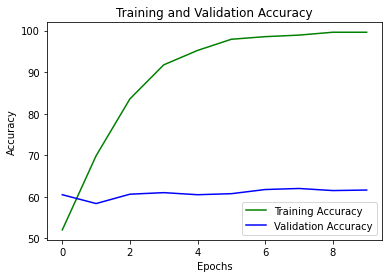

88.696875
60.8625


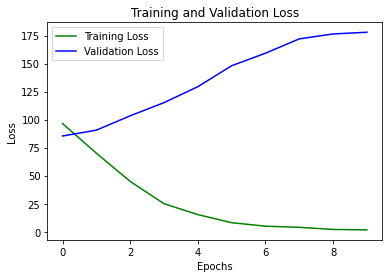

27.20584692740813
135.73180592977084
              precision    recall  f1-score   support

           0       0.62      0.76      0.69       316
           1       0.66      0.58      0.62       237
           2       0.66      0.60      0.63       447

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.64      1000
weighted avg       0.65      0.65      0.64      1000

accuracy = 0.65


In [ ]:
# del model
# gc.collect()
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                     num_labels=3,
                                                     output_attentions=False,
                                                     output_hidden_states=False,
                                                     )
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)

epochs=10
total_steps = len(train_data_loader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps=0,
                                           num_training_steps=total_steps)

total_t0 = time.time()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

best_macro_f1 = float('0')

train_acc_hs = []
val_acc_hs = []
train_loss_hs = []
val_loss_hs = []
best_logits = []

for epoch in range(epochs):
    
    start_time = time.time()
    train_loss, train_acc, logits = train(model, optimizer, train_data_loader)
    valid_loss, valid_acc, macro_f1 = evaluate(model, valid_data_loader)
    
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if macro_f1 > best_macro_f1:
        best_logits = logits
        print(len(best_logits))
        best_macro_f1 = macro_f1
        torch.save(model,'/content/gdrive/MyDrive/CSS Project/models/model_implicit_tune_TA_comments.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    train_acc_hs.append(train_acc*100)
    val_acc_hs.append(valid_acc*100)
    train_loss_hs.append(train_loss*100)
    val_loss_hs.append(valid_loss*100)


plot_vc(train_acc_hs, val_acc_hs)
print(np.mean(train_acc_hs))
print(np.mean(val_acc_hs))

plot_lc(train_loss_hs, val_loss_hs)
print(np.mean(train_loss_hs))
print(np.mean(val_loss_hs))

# EVALUATE MODEL
import gc
del model
gc.collect()

model = torch.load("/content/gdrive/MyDrive/CSS Project/models/model_implicit_tune_TA_comments.pt")
model = model.to(device)

valid_loss,valid_acc,all_sentence_id,all_pred_labels = evaluate_test(model, test_data_loader)

In [ ]:
best_logits = [t.cpu().detach().numpy() for t in best_logits]
pd.DataFrame(best_logits, columns=['0', '1', '2']).to_csv('/content/gdrive/MyDrive/CSS Project/models/bert_output_logits_3e-5.csv')

In [ ]:
del model
gc.collect()

model = torch.load("/content/gdrive/MyDrive/CSS Project/models/model_implicit_tune_TA_comments.pt")
model = model.to(device)

valid_loss,valid_acc,all_sentence_id,all_pred_labels = evaluate_test(model, test_data_loader)

              precision    recall  f1-score   support

           0       0.62      0.76      0.69       316
           1       0.66      0.58      0.62       237
           2       0.66      0.60      0.63       447

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.64      1000
weighted avg       0.65      0.65      0.64      1000

accuracy = 0.65


# Annotate Datasets

In [ ]:
import gc
del model
gc.collect()

model = torch.load("/content/gdrive/MyDrive/CSS Project/models/model_implicit_tune_TA_comments.pt")
model = model.to(device)

In [ ]:
import glob
import re
dataset_paths = glob.glob("/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/SubReddits/*.csv")
file_names = np.array([re.findall(r'[^\/]+(?=\.)', path) for path in dataset_paths]).flatten()
num_files = len(file_names)
file_names

array(['Top_Posts_news', 'Top_Posts_politics', 'Top_Posts_atleticomadrid',
       'Top_Posts_cats', 'Top_Posts_championsleague', 'Top_Posts_gaming',
       'Top_Posts_pets', 'Top_Posts_premierleague', 'Top_Posts_reddevils',
       'Top_Posts_realmadrid', 'Top_Posts_europe'], dtype='<U25')

In [ ]:
predicted_datasets = {}
for i in range(num_files):
    path = dataset_paths[i]
    fname = file_names[i]

    df = pd.read_csv(path)
    df = pd.DataFrame(df['Title'])

    # print(df.shape)
    # print(df.columns)
    # print(df.head(2))
    print("fname: ", fname, "post count: ", df.shape)

    df_sent_index,df_ids,df_attention_masks = encoder_generator(list(df['Title']))
    # print("sent_index.shape, input_ids.shape, attention_masks.shape ", type(newsdf_sent_index), type(newsdf_ids), type(newsdf_attention_masks))
    # print('Original: ', df['Title'][0])
    # print('Token IDs:', df_ids[0])
    dataset = TensorDataset(df_sent_index, df_ids, df_attention_masks)
    bs=8
    data_loader = DataLoader(dataset,
                                sampler=SequentialSampler(dataset),
                                batch_size=bs)

    all_sentence_id,all_pred_labels = predict_logits(model, data_loader)

    output_data_labels = df.copy(deep=True)
    output_data_labels['labels'] = all_pred_labels
    # output_data_labels['labels'] = output_data_labels['labels'].replace([2,0,1],['implicit_hate','not_hate','explicit_hate'])
    # print("Prediction Summary: ", collections.Counter(all_pred_labels))
    # print(output_data_labels[output_data_labels['predicted_labels']>0])
    predicted_datasets[fname] = output_data_labels

fname:  Top_Posts_news post count:  (100, 1)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


fname:  Top_Posts_politics post count:  (100, 1)
fname:  Top_Posts_atleticomadrid post count:  (2, 1)
fname:  Top_Posts_cats post count:  (100, 1)
fname:  Top_Posts_championsleague post count:  (78, 1)
fname:  Top_Posts_gaming post count:  (100, 1)
fname:  Top_Posts_pets post count:  (100, 1)
fname:  Top_Posts_premierleague post count:  (100, 1)
fname:  Top_Posts_reddevils post count:  (100, 1)
fname:  Top_Posts_realmadrid post count:  (100, 1)
fname:  Top_Posts_europe post count:  (100, 1)


In [ ]:
for fname in file_names:
  print(fname)
  data = predicted_datasets[fname]
  print("Prediction Summary: ", collections.Counter(data['labels']))
  print()
  print("Hateful posts with labels")
  print(data[data['labels']>0])
  print("-----------------------------------------------")
  print("-----------------------------------------------")
  print()

# Europe

Annotate the reddit posts collected for r/Europe

In [ ]:
dir_name = "europe"

gc.collect()

model = torch.load("/content/gdrive/MyDrive/CSS Project/models/model_implicit_tune_TA_comments.pt")
model = model.to(device)

dataset_paths = glob.glob("/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/SubReddits/"+dir_name+"/*.csv")
file_names = np.array([re.findall(r'[^\/]+(?=\.)', path) for path in dataset_paths]).flatten()
num_files = len(file_names)
print("number of files: ", num_files)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

predicted_datasets = {}
for i in range(num_files):
    path = dataset_paths[i]
    fname = file_names[i]

    posts = pd.read_csv(path, parse_dates=True, index_col='Created')
    posts['Title'] = modify_tweets(posts['Title'])
    df = pd.DataFrame(posts['Title'])
    print("fname: ", fname, "post count: ", df.shape)

    df_sent_index,df_ids,df_attention_masks = encoder_generator(list(df['Title']))
    dataset = TensorDataset(df_sent_index, df_ids, df_attention_masks)
    bs=8
    data_loader = DataLoader(dataset,
                                sampler=SequentialSampler(dataset),
                                batch_size=bs)

    all_sentence_id,all_pred_labels = predict_logits(model, data_loader)

    output_data_labels = df.copy(deep=True)
    output_data_labels['labels'] = all_pred_labels
    predicted_datasets[fname] = output_data_labels
    
print()
print()
summary = {}
for fname in file_names:
    data = predicted_datasets[fname]
    data['labels'] = data['labels'].replace([2,0,1], ['implicit_hate','not_hate','explicit_hate'])
    summary[fname] = collections.Counter(data['labels'])
    pout = "/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/SubReddits/OUTPUT/"+dir_name+"/"+fname+".csv"
    data.to_csv(pout)
    # print()
    # print("Hateful posts with labels")
    # print(data[data['labels']>0])
    # print("-----------------------------------------------")
    # print("-----------------------------------------------")
    # print()
distribution = pd.DataFrame(summary).fillna(value=0).transpose()
distribution.to_csv("/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/SubReddits/OUTPUT/"+dir_name+"/summary.csv")
distribution

number of files:  18
fname:  Posts_europe_12 post count:  (99, 1)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


fname:  Posts_europe_2 post count:  (100, 1)
fname:  Posts_europe_11 post count:  (99, 1)
fname:  Posts_europe_7 post count:  (100, 1)
fname:  Posts_europe_16 post count:  (100, 1)
fname:  Posts_europe_14 post count:  (100, 1)
fname:  Posts_europe_17 post count:  (99, 1)
fname:  Posts_europe_0 post count:  (100, 1)
fname:  Posts_europe_9 post count:  (100, 1)
fname:  Posts_europe_8 post count:  (100, 1)
fname:  Posts_europe_13 post count:  (100, 1)
fname:  Posts_europe_4 post count:  (100, 1)
fname:  Posts_europe_15 post count:  (99, 1)
fname:  Posts_europe_6 post count:  (100, 1)
fname:  Posts_europe_1 post count:  (100, 1)
fname:  Posts_europe_10 post count:  (100, 1)
fname:  Posts_europe_3 post count:  (100, 1)
fname:  Posts_europe_5 post count:  (100, 1)




,not_hate,implicit_hate,explicit_hate
Posts_europe_12,79.0,18.0,2.0
Posts_europe_2,87.0,10.0,3.0
Posts_europe_11,94.0,4.0,1.0
Posts_europe_7,86.0,13.0,1.0
Posts_europe_16,90.0,10.0,0.0
Posts_europe_14,75.0,24.0,1.0
Posts_europe_17,85.0,14.0,0.0
Posts_europe_0,83.0,17.0,0.0
Posts_europe_9,86.0,13.0,1.0
Posts_europe_8,86.0,13.0,1.0


## Result analysis

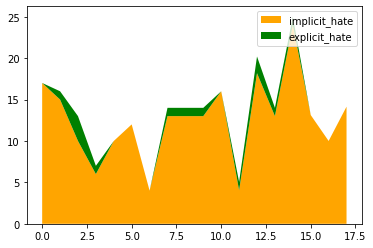

In [ ]:
dir_name = "europe"

summary = pd.read_csv("/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/SubReddits/OUTPUT/"+dir_name+"/summary.csv")
col = summary.columns[0]
summary[col] = np.array([re.findall(r'[0-9]+', name) for name in summary[col]], dtype=np.uint8).flatten()
sorted_summary = summary.sort_values(by=[col])
labels = sorted_summary[col]
# total = list(sorted_summary[1:].sum(axis=1))
# impl_values = np.divide(list(sorted_summary['implicit_hate']),total)
# expl_values = np.divide(list(sorted_summary['explicit_hate']),total)
# print(list(expl_values))
i = list(sorted_summary['implicit_hate'])
e = list(sorted_summary['explicit_hate'])
n = list(sorted_summary['not_hate'])
total = np.sum([i, e, n], axis=0)

plt.figure(0)
# plt.stackplot(labels, impl_values, colors =['orange'], labels=['implicit_hate'])
plt.stackplot(labels, np.divide(i,total)*100, np.divide(e,total)*100, baseline='zero', colors =['orange', 'green'], labels=['implicit_hate', 'explicit_hate'])
plt.legend()
# plt.figure(0)
# plt.stackplot(labels, expl_values, colors =['green'], labels=['explicit_hate'])
# plt.legend()

# Politics

Annotate the reddit posts collected for r/Politics

In [ ]:
dir_name = "politics"

gc.collect()

model = torch.load("/content/gdrive/MyDrive/CSS Project/models/model_implicit_tune_TA_comments.pt")
model = model.to(device)

dataset_paths = glob.glob("/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/SubReddits/"+dir_name+"/*.csv")
file_names = np.array([re.findall(r'[^\/]+(?=\.)', path) for path in dataset_paths]).flatten()
num_files = len(file_names)
print("number of files: ", num_files)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

predicted_datasets = {}
for i in range(num_files):
    path = dataset_paths[i]
    fname = file_names[i]

    posts = pd.read_csv(path, parse_dates=True, index_col='Created')
    posts['Title'] = modify_tweets(posts['Title'])
    df = pd.DataFrame(posts['Title'])

    print("fname: ", fname, "post count: ", df.shape)

    df_sent_index,df_ids,df_attention_masks = encoder_generator(list(df['Title']))
    dataset = TensorDataset(df_sent_index, df_ids, df_attention_masks)
    bs=8
    data_loader = DataLoader(dataset,
                                sampler=SequentialSampler(dataset),
                                batch_size=bs)

    all_sentence_id,all_pred_labels = predict_logits(model, data_loader)

    output_data_labels = df.copy(deep=True)
    output_data_labels['labels'] = all_pred_labels
    predicted_datasets[fname] = output_data_labels

summary = {}
for fname in file_names:
    data = predicted_datasets[fname]
    data['labels'] = data['labels'].replace([2,0,1], ['implicit_hate','not_hate','explicit_hate'])
    summary[fname] = collections.Counter(data['labels'])
    pout = "/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/SubReddits/OUTPUT/"+dir_name+"/"+fname+".csv"
    data.to_csv(pout)
    # print()
    # print("Hateful posts with labels")
    # print(data[data['labels']>0])
    # print("-----------------------------------------------")
    # print("-----------------------------------------------")
    # print()
distribution = pd.DataFrame(summary).fillna(value=0).transpose()
distribution.to_csv("/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/SubReddits/OUTPUT/"+dir_name+"/summary.csv")
distribution

number of files:  158
fname:  Posts_politics_83 post count:  (99, 1)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


fname:  Posts_politics_30 post count:  (100, 1)
fname:  Posts_politics_85 post count:  (99, 1)
fname:  Posts_politics_89 post count:  (100, 1)
fname:  Posts_politics_32 post count:  (100, 1)
fname:  Posts_politics_136 post count:  (100, 1)
fname:  Posts_politics_64 post count:  (100, 1)
fname:  Posts_politics_139 post count:  (100, 1)
fname:  Posts_politics_50 post count:  (100, 1)
fname:  Posts_politics_7 post count:  (100, 1)
fname:  Posts_politics_125 post count:  (100, 1)
fname:  Posts_politics_92 post count:  (100, 1)
fname:  Posts_politics_126 post count:  (100, 1)
fname:  Posts_politics_36 post count:  (100, 1)
fname:  Posts_politics_107 post count:  (100, 1)
fname:  Posts_politics_152 post count:  (100, 1)
fname:  Posts_politics_113 post count:  (99, 1)
fname:  Posts_politics_26 post count:  (100, 1)
fname:  Posts_politics_18 post count:  (99, 1)
fname:  Posts_politics_52 post count:  (100, 1)
fname:  Posts_politics_4 post count:  (100, 1)
fname:  Posts_politics_59 post count: 

,not_hate,explicit_hate,implicit_hate
Posts_politics_83,92.0,2.0,5.0
Posts_politics_30,96.0,0.0,4.0
Posts_politics_85,88.0,0.0,11.0
Posts_politics_89,97.0,0.0,3.0
Posts_politics_32,96.0,2.0,2.0
...,...,...,...
Posts_politics_84,92.0,1.0,7.0
Posts_politics_135,99.0,0.0,1.0
Posts_politics_146,98.0,0.0,2.0
Posts_politics_68,88.0,1.0,10.0


## Result analysis

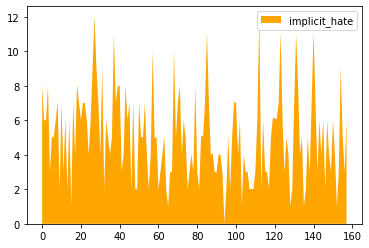

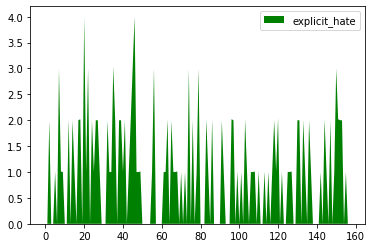

In [ ]:
dir_name = "politics"

summary = pd.read_csv("/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/SubReddits/OUTPUT/"+dir_name+"/summary.csv")
col = summary.columns[0]
summary[col] = np.array([re.findall(r'[0-9]+', name) for name in summary[col]], dtype=np.uint8).flatten()
sorted_summary = summary.sort_values(by=[col])
labels = sorted_summary[col]
# impl_values = sorted_summary['implicit_hate']
# expl_values = sorted_summary['explicit_hate']

i = list(sorted_summary['implicit_hate'])
e = list(sorted_summary['explicit_hate'])
n = list(sorted_summary['not_hate'])
total = np.sum([i, e, n], axis=0)

plt.figure(0)
plt.stackplot(labels, np.divide(i,total)*100, colors =['orange'], labels=['implicit_hate'])
# plt.stackplot(labels, impl_values, expl_values, colors =['orange', 'green'], labels=['implicit_hate', 'explicit_hate'])
plt.legend()
plt.figure(1)
plt.stackplot(labels, np.divide(e,total)*100, colors =['green'], labels=['explicit_hate'])
plt.legend()

# Champions League

Annotate the reddit posts collected for r/ChampionsLeague

In [ ]:
dir_name= "championsleague"

gc.collect()

model = torch.load("/content/gdrive/MyDrive/CSS Project/models/model_implicit_tune_TA_comments.pt")
model = model.to(device)

dataset_paths = glob.glob("/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/SubReddits/"+dir_name+"/*.csv")
file_names = np.array([re.findall(r'[^\/]+(?=\.)', path) for path in dataset_paths]).flatten()
num_files = len(file_names)
print("number of files: ", num_files)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

predicted_datasets = {}
for i in range(num_files):
    path = dataset_paths[i]
    fname = file_names[i]

    posts = pd.read_csv(path, parse_dates=True, index_col='Created')
    posts['Title'] = modify_tweets(posts['Title'])
    df = pd.DataFrame(posts['Title'])

    print("fname: ", fname, "post count: ", df.shape)

    df_sent_index,df_ids,df_attention_masks = encoder_generator(list(df['Title']))
    dataset = TensorDataset(df_sent_index, df_ids, df_attention_masks)
    bs=8
    data_loader = DataLoader(dataset,
                                sampler=SequentialSampler(dataset),
                                batch_size=bs)

    all_sentence_id,all_pred_labels = predict_logits(model, data_loader)

    output_data_labels = df.copy(deep=True)
    output_data_labels['labels'] = all_pred_labels
    predicted_datasets[fname] = output_data_labels

summary = {}
for fname in file_names:
    data = predicted_datasets[fname]
    data['labels'] = data['labels'].replace([2,0,1], ['implicit_hate','not_hate','explicit_hate'])
    summary[fname] = collections.Counter(data['labels'])
    pout = "/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/SubReddits/OUTPUT/"+dir_name+"/"+fname+".csv"
    data.to_csv(pout)
    # print()
    # print("Hateful posts with labels")
    # print(data[data['labels']>0])
    # print("-----------------------------------------------")
    # print("-----------------------------------------------")
    # print()
distribution = pd.DataFrame(summary).fillna(value=0).transpose()
distribution.to_csv("/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/SubReddits/OUTPUT/"+dir_name+"/summary.csv")
distribution

number of files:  60
fname:  Posts_championsleague_26 post count:  (100, 1)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


fname:  Posts_championsleague_13 post count:  (100, 1)
fname:  Posts_championsleague_15 post count:  (100, 1)
fname:  Posts_championsleague_36 post count:  (100, 1)
fname:  Posts_championsleague_31 post count:  (100, 1)
fname:  Posts_championsleague_55 post count:  (100, 1)
fname:  Posts_championsleague_33 post count:  (100, 1)
fname:  Posts_championsleague_12 post count:  (100, 1)
fname:  Posts_championsleague_25 post count:  (100, 1)
fname:  Posts_championsleague_16 post count:  (100, 1)
fname:  Posts_championsleague_24 post count:  (100, 1)
fname:  Posts_championsleague_9 post count:  (100, 1)
fname:  Posts_championsleague_17 post count:  (100, 1)
fname:  Posts_championsleague_56 post count:  (100, 1)
fname:  Posts_championsleague_38 post count:  (100, 1)
fname:  Posts_championsleague_18 post count:  (100, 1)
fname:  Posts_championsleague_50 post count:  (100, 1)
fname:  Posts_championsleague_5 post count:  (100, 1)
fname:  Posts_championsleague_3 post count:  (100, 1)
fname:  Posts

,not_hate,implicit_hate,explicit_hate
Posts_championsleague_26,95.0,5.0,0.0
Posts_championsleague_13,93.0,6.0,1.0
Posts_championsleague_15,93.0,6.0,1.0
Posts_championsleague_36,92.0,5.0,3.0
Posts_championsleague_31,93.0,4.0,3.0
Posts_championsleague_55,94.0,4.0,2.0
Posts_championsleague_33,92.0,5.0,3.0
Posts_championsleague_12,93.0,6.0,1.0
Posts_championsleague_25,95.0,5.0,0.0
Posts_championsleague_16,93.0,6.0,1.0


## Result analysis

<Figure size 432x288 with 0 Axes>

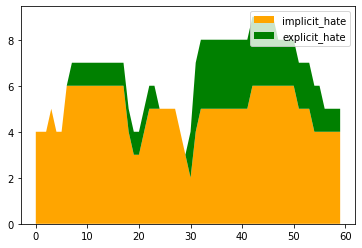

<Figure size 432x288 with 0 Axes>

In [ ]:
dir_name = "championsleague"

summary = pd.read_csv("/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/SubReddits/OUTPUT/"+dir_name+"/summary.csv")
col = summary.columns[0]
summary[col] = np.array([re.findall(r'[0-9]+', name) for name in summary[col]], dtype=np.uint8).flatten()
sorted_summary = summary.sort_values(by=[col])
labels = sorted_summary[col]
# impl_values = sorted_summary['implicit_hate']
# expl_values = sorted_summary['explicit_hate']

i = list(sorted_summary['implicit_hate'])
e = list(sorted_summary['explicit_hate'])
n = list(sorted_summary['not_hate'])
total = np.sum([i, e, n], axis=0)

plt.figure(0)
# plt.stackplot(labels, impl_values, colors =['orange'], labels=['implicit_hate'])
plt.stackplot(labels, np.divide(i,total)*100, np.divide(e,total)*100, colors =['orange', 'green'], labels=['implicit_hate', 'explicit_hate'])
plt.legend() 
plt.figure(1)
# plt.stackplot(labels, expl_values, colors =['green'], labels=['explicit_hate'])
# plt.legend()

# Generate dataset for human annotation

In [ ]:
directories = ["politics"]
posts = []
for dir_name in directories:
    gc.collect()

    dataset_paths = glob.glob("/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/SubReddits/OUTPUT/"+dir_name+"/Posts*.csv")
    file_names = np.array([re.findall(r'[^\/]+(?=\.)', path) for path in dataset_paths]).flatten()
    num_files = len(file_names)
    print("number of files: ", num_files)

    for i, fname in enumerate(file_names):
        path = dataset_paths[i]
        data = pd.read_csv(path)
        data['labels'] = data['labels'].replace(['implicit_hate','not_hate','explicit_hate'],[2,0,1])
        hs_posts = list(data[data['labels']>0]['Title'][::2])
        posts.extend(hs_posts)
        posts.extend(np.random.choice(data[data['labels']==0]['Title'], int(len(hs_posts)*0.5)))
    print(len(posts))
random.shuffle(posts)
pd.DataFrame(posts).to_csv("/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/SubReddits/OUTPUT/human_annotation_posts.csv")

number of files:  158
727


In [ ]:
directories = ["politics", "europe", "championsleague"]
exp = {}
imp = {}
noths = {}
total = {}
for dir_name in directories:
    gc.collect()
    exp[dir_name] = 0
    imp[dir_name] = 0
    noths[dir_name] = 0
    total[dir_name] = 0

    dataset_paths = glob.glob("/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/SubReddits/OUTPUT/"+dir_name+"/Posts*.csv")
    file_names = np.array([re.findall(r'[^\/]+(?=\.)', path) for path in dataset_paths]).flatten()
    num_files = len(file_names)
    print("number of files: ", num_files)
    for i, fname in enumerate(file_names):
        path = dataset_paths[i]
        data = pd.read_csv(path)
        data['labels'] = data['labels'].replace(['implicit_hate','not_hate','explicit_hate'],[2,0,1])
        exp[dir_name] += data[data['labels']==1].shape[0]
        imp[dir_name] += data[data['labels']==2].shape[0]
        noths[dir_name] += data[data['labels']==0].shape[0]
        total[dir_name] += data.shape[0]
print(exp)
print(imp)
print(noths)
print(total)

number of files:  158
number of files:  18
number of files:  60
{'politics': 146, 'europe': 13, 'championsleague': 89}
{'politics': 793, 'europe': 225, 'championsleague': 297}
{'politics': 14815, 'europe': 1558, 'championsleague': 5614}
{'politics': 15754, 'europe': 1796, 'championsleague': 6000}


# ETHOS

In [ ]:
dir_name = "ethos"

gc.collect()

model = torch.load("/content/gdrive/MyDrive/CSS Project/models/model_implicit_tune_TA_comments.pt")
model = model.to(device)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

path = "/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/YoutubeReddit/"+dir_name+".csv"

posts = pd.read_csv(path)
print(posts.head(5))

# posts['comment'] = modify_tweets(posts['comment'])
df = pd.DataFrame(posts['comment'])
print("post count: ", df.shape)

df_sent_index,df_ids,df_attention_masks = encoder_generator(list(df['comment']))
dataset = TensorDataset(df_sent_index, df_ids, df_attention_masks)
bs=8
data_loader = DataLoader(dataset,
                            sampler=SequentialSampler(dataset),
                            batch_size=bs)

all_sentence_id,all_pred_labels = predict_logits(model, data_loader)

output_data_labels = df.copy(deep=True)
output_data_labels['labels'] = all_pred_labels
output_data_labels['isHate'] = posts['hate_binary']

data = output_data_labels
data['labels'] = data['labels'].replace([2,0,1], ['implicit_hate','not_hate','explicit_hate'])
pout = "/content/gdrive/MyDrive/CSS Project/implicit-hate-corpus/YoutubeReddit/OUTPUT/"+dir_name+".csv"
data.to_csv(pout)

                                             comment  isHate  hate_binary
0          You should know women's sports are a joke     1.0         True
1    You look like Sloth with deeper Down’s syndrome     1.0         True
2  You look like Russian and speak like Indian. B...     1.0         True
3               Women deserve to be abused, I guess.     1.0         True
4  Women are made for making babies and cooking d...     1.0         True
post count:  (998, 1)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
implicit_hate = data[data['labels']=='implicit_hate']
explicit_hate = data[data['labels']=='explicit_hate']
not_hate = data[data['labels']=='not_hate']

total = np.array([len(implicit_hate), len(explicit_hate), len(not_hate)])
i = collections.Counter(implicit_hate['isHate'])
e = collections.Counter(explicit_hate['isHate'])
n = collections.Counter(not_hate['isHate'])
print(i[True])
hate = np.array([i[True], e[True], n[True]])
not_hate = np.array([i[False], e[False], n[False]])

print('Implicit Hate')
print("total : ", len(implicit_hate))
print(collections.Counter(implicit_hate['isHate']))

173
Implicit Hate
total :  468
Counter({False: 295, True: 173})


# Results Analysis

In [ ]:
pd.DataFrame(np.round(np.array([total/total, hate/total, not_hate/total]), 3)*100, columns=['Imp', 'Exp', 'Not'], index=['total', 'hate', 'not hate'])

,Imp,Exp,Not
total,100.0,100.0,100.0
hate,37.0,73.0,6.0
not hate,63.0,27.0,94.0


In [ ]:
pd.DataFrame(np.array([total, hate, not_hate]), columns=['Imp', 'Exp', 'Not'], index=['total', 'hate', 'not hate'])

,Imp,Exp,Not
total,468,230,300
hate,173,168,18
not hate,295,62,282
